(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)
(10000, 784)
(10000, 10)
epoch:  0
training loss:  0.6398606392747848
training error:  0.1694
validation loss:  0.44113246854317584
validation error:  0.1314
epoch:  1
training loss:  0.38414453786409936
training error:  0.1139
validation loss:  0.38804030829078273
validation error:  0.118
epoch:  2
training loss:  0.35330287431872615
training error:  0.1063
validation loss:  0.33856041541580456
validation error:  0.0987
epoch:  3
training loss:  0.33884208023220397
training error:  0.1027
validation loss:  0.34691282045110344
validation error:  0.106
epoch:  4
training loss:  0.3247866983635539
training error:  0.0983
validation loss:  0.3318364911898872
validation error:  0.104
epoch:  5
training loss:  0.3154556772605511
training error:  0.09578
validation loss:  0.318316021945797
validation error:  0.0963
epoch:  6
training loss:  0.3086698577574938
training error:  0.09388
validation loss:  0.30531058184781984
validation error:  0.

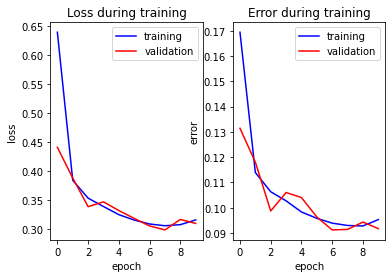

In [2]:
# Do not import any additional 3rd party external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import pdb

class Activation(object):

    """
    Interface for activation functions (non-linearities).
    """

    # No additional work is needed for this class, as it acts like an abstract base class for the others

    def __init__(self):
        self.state = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        raise NotImplemented

    def derivative(self):
        raise NotImplemented


class Identity(Activation):

    """
    Identity function (already implemented).
    """

    # This class is a gimme as it is already implemented for you as an example (do not change)

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        self.state = x
        return x

    def derivative(self):
        return 1.0


class Sigmoid(Activation):

    """
    Sigmoid non-linearity
    """

    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, x, linear):
        # sigmoid
        self.x = x
        self.linear = linear
        self.saved = 1/(1+np.exp(-self.linear))
        return self.saved

    def derivative(self):
        # deriv of sigmoid is a diagonal matrix
        # a(1-a) if diagonal, 0 o/w
        dim = self.saved.shape[1] 
        diag = np.eye(dim)
        for i in range(dim):
            elem_i = self.saved[0][i] * (1-self.saved[0][i])
            diag[i][i] = elem_i
        # diag[range(dim),range(dim)] = self.saved * (1-self.saved)
        return diag

class Tanh(Activation):

    """
    Tanh non-linearity
    """

    def __init__(self):
        super(Tanh, self).__init__()

    def forward(self, x):
        # tanh(x)
        self.saved = (2/(1+np.exp(-2*x))) - 1
        return self.saved 

    def derivative(self):
        # 1 - (tanh(x))^2
        return 1-(self.saved**2)


class ReLU(Activation):

    """
    ReLU non-linearity
    """

    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        self.saved = max(0,x)
        return self.saved

    def derivative(self):
        return self.saved * (self.saved >= 0)


class Criterion(object):

    """
    Interface for loss functions.
    """

    # Nothing needs done to this class, it's used by the following Criterion classes

    def __init__(self):
        self.logits = None
        self.labels = None
        self.loss = None

    def __call__(self, x, y):
        return self.forward(x, y)

    def forward(self, x, y):
        raise NotImplemented

    def derivative(self):
        raise NotImplemented


class SoftmaxCrossEntropy(Criterion):

    """
    Softmax loss
    """

    def __init__(self):
        super(SoftmaxCrossEntropy, self).__init__()
        self.loss = None
        self.o, self.y = None, None
        # you can add variables if needed

    def forward(self, o, y):
        n = y.shape[0]
        # y_hat: softmax predictions
        # y: one-hot true labels
        self.o, self.y = o, y
        y_idx = self.y.argmax(axis=1)

        ll = -np.log(self.o[range(n), y_idx])
        self.loss = np.sum(ll)
        return self.loss

    def derivative(self):
        # print("cross entropy derivative", self.o.shape, self.y.shape)
        return self.o - self.y


# randomly intialize the weight matrix with dimension d0 x d1 via Normal distribution
def random_normal_weight_init(d0, d1):
    W = np.random.normal(size=(d0,d1))
    return W


# initialize a d-dimensional bias vector with all zeros
def zeros_bias_init(d):
    b = np.zeros((1,d))
    return b


def softmax(x):
    exp = np.exp(x)
    sm  = exp / np.sum(exp, axis=1, keepdims=True)
    return(sm)



class MLP(object):

    """
    A simple multilayer perceptron
    (feel free to add class functions if needed)
    """

    def __init__(self, input_size, output_size, hiddens, activations, weight_init_fn, bias_init_fn, criterion, lr):

        self.num_hiddens = len(hiddens)
    
        # Don't change this -->
        self.train_mode = True
        self.nlayers = self.num_hiddens + 1
        self.input_size = input_size
        self.output_size = output_size
        self.activations = activations
        self.criterion = criterion
        self.lr = lr
        self.o = None # softmax outputs 
        # <---------------------

        # Don't change the name of the following class attributes
        self.nn_dim = [input_size] + hiddens + [output_size]
        # list containing Weight matrices of each layer, each should be a np.array
        # self.W = [weight_init_fn(self.nn_dim[i], self.nn_dim[i+1]) for i in range(self.nlayers)]
        self.W = np.array([0,0], dtype=object)
        for i in range(self.nlayers):
            self.W[i] = weight_init_fn(self.nn_dim[i], self.nn_dim[i+1])
        # self.W = np.asarray([weight_init_fn(self.nn_dim[i], self.nn_dim[i+1]) for i in range(self.nlayers)], dtype=object)
        # list containing derivative of Weight matrices of each layer, each should be a np.array
        self.dW = [np.zeros_like(weight) for weight in self.W]

        # list containing bias vector of each layer, each should be a np.array
        # self.b = [bias_init_fn(self.nn_dim[i+1]) for i in range(self.nlayers)]
        # self.b = np.asarray([bias_init_fn(self.nn_dim[i+1]) for i in range(self.nlayers)],dtype=object)
        # list containing derivative of bias vector of each layer, each should be a np.array
        self.b = np.array([0,0], dtype=object)
        for i in range(self.nlayers):
            self.b[i] = bias_init_fn(self.nn_dim[i+1])
        self.db = [np.zeros_like(bias) for bias in self.b]

    # input x: batch_size * 784
    # hidden layer: 784 -> 128 
    # output layer: 128 -> 10
    def forward(self, x):
        # -- linear, f1 = x * W0 + b0
        self.f1 = np.dot(x, self.W[0]) + self.b[0]
        # -- sigmoid, a = sigmoid(f1)
        self.a = self.activations[0].forward(x, self.f1)

        # -- linear, f2 = a * W1 + b1
        self.f2 = np.dot(self.a, self.W[1]) + self.b[1]
        # -- softmax, o = Softmax(f2)
        self.o = softmax(self.f2)


    def zero_grads(self):
        # set dW and db to be zero
        self.dW = [np.zeros_like(weight) for weight in self.W]
        self.db = [np.zeros_like(bias) for bias in self.b]

    def step(self):     
        # update the W and b on each layer
        for i in range(self.nlayers):
            self.W[i] = self.W[i] - self.lr * self.dW[i].T
            self.b[i] = self.b[i] - self.lr * self.db[i]

    def backward(self, labels):
        self.loss = self.criterion.forward(self.o, labels)

        if self.train_mode:
            # calculate dW and db only under training mode
            df2 = self.db[1] =  self.criterion.derivative() # deriv of softmax
            # print('dE/df2', df2.shape) #dE/df2: 1xK
            # print('df2/da', self.W[1].T.shape) # df2/da: KxM
            da               =  df2 @ self.W[1].T
            self.dW[1]       =  df2.T @ self.a
            df1 = self.db[0] =  da @ self.activations[0].derivative()
            # print('da/df1',self.activations[0].derivative().shape) # da/df1
            self.dW[0]       =  df1.T @ self.activations[0].x
            # print('df1/dx', self.W[0].T.shape) # df1/dx MxN
            # exit(0)

    def __call__(self, x):
        return self.forward(x)

    def train(self):
        # training mode
        self.train_mode = True

    def eval(self):
        # evaluation mode
        self.train_mode = False

    def get_loss(self, labels):
        # return the current loss value given labels
        return self.criterion.forward(self.o, labels)

    def get_error(self, labels):
        # return the number of incorrect preidctions gievn labels
        count = 0
        o_idx = self.o.argmax(axis=1)
        y_idx = labels.argmax(axis=1)
        for i in range(len(o_idx)):
            if o_idx[i] != y_idx[i]:
                count += 1
        return count

    def save_model(self, path='p1_model.npz'):
        # save the parameters of MLP (do not change)
        np.savez(path, self.W, self.b)


# Don't change this function
def get_training_stats(mlp, dset, nepochs, batch_size):
    train, val, test = dset
    trainx, trainy = train
    valx, valy = val
    testx, testy = test

    idxs = np.arange(len(trainx))

    training_losses = []
    training_errors = []
    validation_losses = []
    validation_errors = []

    for e in range(nepochs):
        print("epoch: ", e)
        train_loss = 0
        train_error = 0
        val_loss = 0
        val_error = 0
        num_train = len(trainx)
        num_val = len(valx)

        for b in range(0, num_train, batch_size):
            mlp.train()
            mlp(trainx[b:b+batch_size])
            mlp.backward(trainy[b:b+batch_size])
            mlp.step()
            train_loss += mlp.get_loss(trainy[b:b+batch_size])
            train_error += mlp.get_error(trainy[b:b+batch_size])
        training_losses += [train_loss/num_train]
        training_errors += [train_error/num_train]
        print("training loss: ", train_loss/num_train)
        print("training error: ", train_error/num_train)

        for b in range(0, num_val, batch_size):
            mlp.eval()
            mlp(valx[b:b+batch_size])
            val_loss += mlp.get_loss(valy[b:b+batch_size])
            val_error += mlp.get_error(valy[b:b+batch_size])
        validation_losses += [val_loss/num_val]
        validation_errors += [val_error/num_val]
        print("validation loss: ", val_loss/num_val)
        print("validation error: ", val_error/num_val)

    test_loss = 0
    test_error = 0
    num_test = len(testx)
    for b in range(0, num_test, batch_size):
        mlp.eval()
        mlp(testx[b:b+batch_size])
        test_loss += mlp.get_loss(testy[b:b+batch_size])
        test_error += mlp.get_error(testy[b:b+batch_size])
    test_loss /= num_test
    test_error /= num_test
    print("test loss: ", test_loss)
    print("test error: ", test_error)

    return (training_losses, training_errors, validation_losses, validation_errors)


# get ont hot key encoding of the label (no need to change this function)
def get_one_hot(in_array, one_hot_dim):
    dim = in_array.shape[0]
    out_array = np.zeros((dim, one_hot_dim))
    for i in range(dim):
        idx = int(in_array[i])
        out_array[i, idx] = 1
    return out_array


def main():
    # load the mnist dataset from csv files
    image_size = 28 # width and length of mnist image
    num_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
    image_pixels = image_size * image_size
    # train_data = np.loadtxt("../mnist/mnist_train.csv", delimiter=",")
    # test_data = np.loadtxt("../mnist/mnist_test.csv", delimiter=",") 
    # np.savez_compressed("../mnist/compressed.npz",train=train_data,test=test_data)

    npz_file = np.load("/content/drive/MyDrive/GoogleColab/compressed.npz")
    train_data = npz_file['train']
    test_data = npz_file['test']

    # rescale image from 0-255 to 0-1
    fac = 1.0 / 255
    train_imgs = np.asfarray(train_data[:50000, 1:]) * fac
    val_imgs = np.asfarray(train_data[50000:, 1:]) * fac
    test_imgs = np.asfarray(test_data[:, 1:]) * fac
    train_labels = np.asfarray(train_data[:50000, :1])
    val_labels = np.asfarray(train_data[50000:, :1])
    test_labels = np.asfarray(test_data[:, :1])

    # convert labels to one-hot-key encoding
    train_labels = get_one_hot(train_labels, num_labels)
    val_labels = get_one_hot(val_labels, num_labels)
    test_labels = get_one_hot(test_labels, num_labels)

    print(train_imgs.shape)
    print(train_labels.shape)
    print(val_imgs.shape)
    print(val_labels.shape)
    print(test_imgs.shape)
    print(test_labels.shape)

    dataset = [
        [train_imgs, train_labels],
        [val_imgs, val_labels],
        [test_imgs, test_labels]
    ]

    # These are only examples of parameters you can start with
    # you can tune these parameters to improve the performance of your MLP
    # this is the only part you need to change in main() function
    hiddens = [128]
    activations = [Sigmoid()]
    lr = 0.05
    num_epochs = 10
    batch_size = 16

    # build your MLP model
    mlp = MLP(
        input_size=image_pixels, 
        output_size=num_labels, 
        hiddens=hiddens, 
        activations=activations, 
        weight_init_fn=random_normal_weight_init, 
        bias_init_fn=zeros_bias_init, 
        criterion=SoftmaxCrossEntropy(), 
        lr=lr
    )

    # train the neural network

    losses = get_training_stats(mlp, dataset, num_epochs, batch_size)

    # save the parameters
    mlp.save_model()

    # visualize the training and validation loss with epochs
    training_losses, training_errors, validation_losses, validation_errors = losses

    fig, (ax1, ax2) = plt.subplots(1, 2)
    

    ax1.plot(training_losses, color='blue', label="training")
    ax1.plot(validation_losses, color='red', label='validation')
    ax1.set_title('Loss during training')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(training_errors, color='blue', label="training")
    ax2.plot(validation_errors, color='red', label="validation")
    ax2.set_title('Error during training')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('error')
    ax2.legend()

    plt.show()


if __name__ == "__main__":
    main()